# 8.3. Network in Network (NiN)

## 📘 Code Along

In [1]:
import torch
from torch import nn

import sys
sys.path.append("../..")
from utils import Classifier
from utils import Trainer
from dataloaders import FashionMNIST

### 8.3.1. NiN Blocks

In [2]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

### 8.3.2. NiN Model

In [3]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class NiN(Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(init_cnn)

In [4]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


### 8.3.3. Training

libc++abi: libc++abi: libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipeterminating due to uncaught exception of type std::__1::system_error: Broken pipe

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10af7c400>
Traceback (most recent call last):
  File "/Users/benediktschink/VSCode/dive-into-deep-learning/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/benediktschink/VSCode/dive-into-deep-learning/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 149, in

KeyboardInterrupt: 

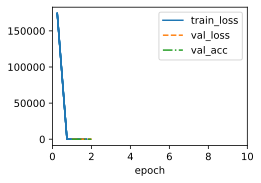

In [5]:
model = NiN(lr=0.05)
trainer = Trainer(max_epochs=10, num_gpus=1)
data = FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)